## Models

The following is a stacked model. This constists of:
LEVEL 0: Catboost, Random Forests, Linear Regressor, KNN, Ridge Regression, SVM, ElasticNet, XGMBoost
LEVEL 1: Linear Regression (As the meta learning model) which uses the StackingRegressor to find the best model.

In [1]:
from catboost import CatBoostRegressor
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn import preprocessing
from numpy import mean
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import copy

In [2]:
# Load data
train = pd.read_csv('final_train.csv')
test = pd.read_csv('final_test.csv')

In [3]:
# Fix differing features
train_objs_num = len(train)
dataset = pd.concat(objs=[train, test], axis=0)
dataset = pd.get_dummies(dataset)
train = copy.copy(dataset[:train_objs_num])
test = copy.copy(dataset[train_objs_num:])

In [4]:
# Check data
print("Training set ", train.shape)
print("Test set ", test.shape)

Training set  (3000, 7207)
Test set  (4398, 7207)


In [5]:
# Fill remaining NA's with 0 and negatives with 0
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)
train[train < 0] = 0
test[test < 0] = 0

In [6]:
# Drop ID Column
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [7]:
# train.describe()

In [8]:
y = train.revenue
X = train.drop('revenue', axis=1)

In [9]:
z = train.sort_values('revenue', ascending=False)
z['revenue']

1126    21.141685
1761    21.132889
2770    21.063590
684     20.956666
2322    20.839934
          ...    
695      0.693147
1917     0.000000
1874     0.000000
1754     0.000000
347      0.000000
Name: revenue, Length: 3000, dtype: float64

In [10]:
# Select Top 50 Best Features
number_of_features = 50
best_features = SelectKBest(score_func=chi2, k=number_of_features)
y = y.astype('int')
fit = best_features.fit(X, y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Specs', 'Score']
print(feature_scores.nlargest(number_of_features, 'Score'))

                                                  Specs         Score
3810                                         cast_score  2.757711e+13
3811                                         crew_score  2.646228e+11
0                                                budget  4.390390e+03
3                                       name_collection  1.631334e+03
3809                                     keywords_count  1.354816e+03
2644        prodc_Québec Production Services Tax Credit  9.990000e+02
2645                    prodc_Abu Dhabi Film Commission  9.990000e+02
2646  prodc_Colorado Office of Film, Television & Media  9.990000e+02
1160                         prodc_Chongoing Film Group  7.490000e+02
1161                       prodc_Bon Voyage Film Studio  7.490000e+02
1162                         prodc_Shanghai Media Group  7.490000e+02
1163      prodc_Zhejiang Films & TV(Group) Company Ltd.  7.490000e+02
1164                    prodc_Hunan Broadcasting System  7.490000e+02
1165                

In [11]:
selected_features = feature_scores.nlargest(number_of_features, 'Score')['Specs'].tolist()

In [12]:
X = X[selected_features]
X.describe()

,cast_score,crew_score,budget,name_collection,keywords_count,prodc_Québec Production Services Tax Credit,prodc_Abu Dhabi Film Commission,"prodc_Colorado Office of Film, Television & Media",prodc_Chongoing Film Group,prodc_Bon Voyage Film Studio,...,prodc_Filmation Associates,prodc_Dharamsala,prodc_Pandemonium,prodc_Lightstream Entertainment,prodc_iFeatures,prodc_Sixty Six Pictures,prodc_Oldgarth Media,prodc_Кинокомпания «Lunapark»,prodc_Инвада фильм,prodc_ABS-CBN Film Productions
count,3.000000e+03,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,2.142649e+09,7.631087e+07,11.959606,1.026360,7.226667,0.000333,0.000333,0.000333,0.000333,0.000333,...,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333
std,6.300792e+09,9.321631e+07,7.405678,2.088409,6.665891,0.018257,0.018257,0.018257,0.018257,0.018257,...,0.018257,0.018257,0.018257,0.018257,0.018257,0.018257,0.018257,0.018257,0.018257,0.018257
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.280491e+08,1.509986e+07,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.560853e+08,5.059708e+07,15.894952,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.892482e+09,1.018539e+08,17.216708,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.817312e+11,9.253127e+08,19.755682,6.045005,149.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
test = test[selected_features]

In [14]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=.2, random_state=13)

In [15]:
k = 5

In [16]:
print('Training: ', X_tr.shape)
print('Validation: ', X_val.shape)
print('Test: ', test.shape)

Training:  (2400, 50)
Validation:  (600, 50)
Test:  (4398, 50)


##### Prep to determine best alpha for some models

In [17]:
# Find the alpha with best value (here we choose 0.001 for ridge regression)
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1,0.5, 1]
for a in alphas:
    model = Ridge(alpha=a, normalize=True).fit(X,y) 
    score = model.score(X, y)
    pred_y = model.predict(X)
    mse = mean_squared_error(y, pred_y) 
    print("Alpha:{0:.6f}, R2:{1:.3f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.000001, R2:0.565, MSE:4.05, RMSE:2.01
Alpha:0.000010, R2:0.565, MSE:4.05, RMSE:2.01
Alpha:0.000100, R2:0.565, MSE:4.05, RMSE:2.01
Alpha:0.001000, R2:0.564, MSE:4.05, RMSE:2.01
Alpha:0.010000, R2:0.555, MSE:4.14, RMSE:2.03
Alpha:0.100000, R2:0.544, MSE:4.24, RMSE:2.06
Alpha:0.500000, R2:0.517, MSE:4.49, RMSE:2.12
Alpha:1.000000, R2:0.484, MSE:4.79, RMSE:2.19


In [18]:
# Best alpha for elasticNet is 0.001
for a in alphas:
    model = ElasticNet(alpha=a, normalize=True).fit(X,y) 
    score = model.score(X, y)
    pred_y = model.predict(X)
    mse = mean_squared_error(y, pred_y) 
    print("Alpha:{0:.6f}, R2:{1:.3f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

/Users/timluo1/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 644.4830549619037, tolerance: 2.789147700000007
  positive)


Alpha:0.000001, R2:0.563, MSE:4.06, RMSE:2.01
Alpha:0.000010, R2:0.553, MSE:4.16, RMSE:2.04
Alpha:0.000100, R2:0.540, MSE:4.28, RMSE:2.07
Alpha:0.001000, R2:0.446, MSE:5.15, RMSE:2.27
Alpha:0.010000, R2:0.113, MSE:8.25, RMSE:2.87
Alpha:0.100000, R2:0.000, MSE:9.30, RMSE:3.05
Alpha:0.500000, R2:0.000, MSE:9.30, RMSE:3.05
Alpha:1.000000, R2:0.000, MSE:9.30, RMSE:3.05


In [19]:
# Prepare the stack
def get_stack():
    layer1 = list()
    layer1.append(('cat_boost', CatBoostRegressor(loss_function='RMSE', logging_level='Silent', depth = 9, early_stopping_rounds = 200, iterations = 1000, eval_metric='RMSE', learning_rate = 0.01)))
    layer1.append(('random_forests', RandomForestRegressor(n_estimators = 3000, max_depth = 9, criterion='mse')))
    layer1.append(('linear_reg', LinearRegression()))
    layer1.append(('knn', KNeighborsRegressor(n_neighbors=10, weights='distance', p=5)))
    layer1.append(('ridge_reg', Ridge(alpha=a, normalize=True)))
    layer1.append(('svr', SVR(kernel='rbf',C=2.0, epsilon=0.2, gamma='auto')))
    layer1.append(('elastic_net', ElasticNet(alpha=a, normalize=True)))
    layer1.append(('xgm', xgb.XGBRegressor()))
    layer2 = list()
    layer2.append(('random_forests2', RandomForestRegressor(n_estimators = 3000, max_depth = 9, criterion='mse')))
    layer2.append(('decision_tree', DecisionTreeRegressor(min_samples_leaf=5, criterion='mse', max_depth=9)))
    layer3 = StackingRegressor(estimators = layer2, final_estimator=LinearRegression(), cv=k)
    model = StackingRegressor(estimators=layer1, final_estimator=layer3, cv=k)
    return model

In [20]:
# Compare with just models themselves without stacking
def get_models():
    models = dict()
    models['cat_boost'] = CatBoostRegressor(loss_function='RMSE', logging_level='Silent', depth = 9, early_stopping_rounds = 200, iterations = 1000, eval_metric='RMSE', learning_rate = 0.01)
    models['random_forests'] = RandomForestRegressor(n_estimators = 3000, max_depth = 9, criterion='mse')
    models['linear_reg'] = LinearRegression()
    models['knn'] = KNeighborsRegressor(n_neighbors=10, weights='distance', p=5)
    models['ridge_reg'] = Ridge(alpha=0.001, normalize=True)
    models['svr'] = SVR(kernel='rbf',C=2.0, epsilon=0.2, gamma='auto')
    models['elastic_net'] = ElasticNet(alpha=0.001, normalize=True)
    models['xgm'] = xgb.XGBRegressor()
    models['stacked'] = get_stack()
    return models

In [21]:
# Cross Validation
def evaluate_model(model):
    cv = KFold(n_splits = k, random_state = 10, shuffle=True)
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=1, error_score='raise')
    return scores

In [22]:
# Workaround to bug in CatBoostRegressor not having attribute n_features_in_
class CatBoostRegressor(CatBoostRegressor):
    def n_features_in_(self):
        return self.get_feature_count()

In [23]:
# Workaround to bug in StackingRegressor not having attribute final_estimator_
class StackingRegressor(StackingRegressor):
    def final_estimator_(self):
        return self.final_estimator_

SCORE OF cat_boost === 1.7842076410006347
SCORE OF random_forests === 1.8133507493201797
SCORE OF linear_reg === 2.1294727508858484
SCORE OF knn === 2.1800623663957728
SCORE OF ridge_reg === 2.131178837675131
SCORE OF svr === 3.0832912700421216
SCORE OF elastic_net === 2.324502771482841
SCORE OF xgm === 1.8878533849313623
SCORE OF stacked === 1.7797402782949228


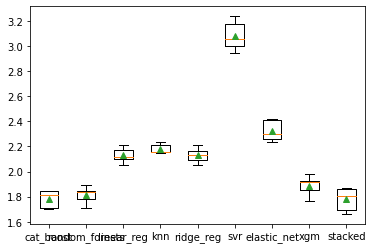

In [24]:
# Show which model is better
models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(-scores)
    names.append(name)
    print("SCORE OF {} === {}".format(name, -mean(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [25]:
# Plots of all models 

In [26]:
# Train and predict stacked model
stack = get_stack()
stack.fit(X, y)
predictions = stack.predict(test)

In [28]:
# Submission
submission = pd.read_csv('Data/sample_submission.csv')
submission['revenue'] = np.expm1(predictions)
submission.to_csv('submission_2.csv', index = False)